In [21]:
#pip install catboost

   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
    --------------------------------------- 1.3/102.4 MB 9.5 MB/s eta 0:00:11
   - -------------------------------------- 3.7/102.4 MB 10.9 MB/s eta 0:00:10
   -- ------------------------------------- 6.3/102.4 MB 11.3 MB/s eta 0:00:09
   --- ------------------------------------ 8.4/102.4 MB 10.8 MB/s eta 0:00:09
   ---- ----------------------------------- 10.7/102.4 MB 11.0 MB/s eta 0:00:09
   ----- ---------------------------------- 13.1/102.4 MB 11.3 MB/s eta 0:00:08
   ------ --------------------------------- 15.7/102.4 MB 11.4 MB/s eta 0:00:08
   ------- -------------------------------- 18.4/102.4 MB 11.5 MB/s eta 0:00:08
   -------- ------------------------------- 21.0/102.4 MB 11.5 MB/s eta 0:00:08
   --------- ------------------------------ 23.1/102.4 MB 11.4 MB/s eta 0:00:07
   ---------- ----------------------------- 26.0/102.4 MB 11.7 MB/s eta 0:00:07
   ----------- ---------------------------- 28.3/102.4

In [98]:
# importing required packages and libraries

import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,accuracy_score,roc_auc_score,roc_curve

In [2]:
# Load the transactions sheet in pandas dataframe
# Read only required columns to save memory
dft = pd.read_excel(r'C:\Users\pravi\Documents\Study\HSBC RC Hackathon 2025\Hackathon-2025-dev\Vikash\transactions_sample_excel.xlsx', 
                    sheet_name='transactions_sample_label', 
                    usecols=['originator_company','originator_country','beneficiary_company','beneficiary_country','amount','currency','date','status'])


In [3]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   originator_company   2000 non-null   object        
 1   originator_country   2000 non-null   object        
 2   beneficiary_company  2000 non-null   object        
 3   beneficiary_country  2000 non-null   object        
 4   amount               2000 non-null   float64       
 5   currency             2000 non-null   object        
 6   status               2000 non-null   object        
 7   date                 2000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 125.1+ KB


In [4]:
dft.head()

,originator_company,originator_country,beneficiary_company,beneficiary_country,amount,currency,status,date
0,"Deleon, Lewis and Myers",Saint Helena,Golden-Fry,Solomon Islands,33807.85,USD,valid,2025-05-31
1,Soto Group,Antigua and Barbuda,Brown Group,Syria,29141.30,USD,invalid,2025-07-04
2,Harrison PLC,Cambodia,"Best, Berg and Charles",Kyrgyz Republic,2749.30,USD,valid,2025-07-01
3,Baxter LLC,Costa Rica,Baxter LLC,Anguilla,23965.96,USD,valid,2025-04-28
4,"Herrera, Davis and Alexander",Sri Lanka,"Herrera, Davis and Alexander",Azerbaijan,35091.88,USD,valid,2025-03-17


In [5]:
# Load references sheet into dataframe
dfr = pd.read_csv(r'C:\Users\pravi\Documents\Study\HSBC RC Hackathon 2025\Hackathon-2025-dev\Vikash\registry_sample.csv')

In [6]:
dfr.head()

,company_id,company_name,country,SIC_code,SIC_desc,NACE_code
0,4fb8575a-1c6d-43ec-a738-7399e2b7d09c,"Ortiz, Williams and Smith",Tokelau,3020,Manufacture of railway locomotives,C30
1,06a37225-4205-4c3c-bbe8-d6dc52507668,"Brown, Cooke and Webster",Syrian Arab Republic,8622,Specialist medical practice activities,Q86
2,77e1ec10-4f7e-4aef-865a-2212a8d271ea,Mullins Inc,Palau,8622,Specialist medical practice activities,Q86
3,7448a02e-98f6-45c8-ab9d-07f0e0b6aba1,"Pham, Watson and Jackson",Armenia,3511,Electric power generation,D35
4,6f1f367d-25a8-46e6-809b-a188a56ef037,Burns-Russell,Poland,3511,Electric power generation,D35


In [7]:
# Are there any duplicates ?
dups = dfr['company_name'].duplicated(keep=False)
print('Number of duplicate rows = %d' % (dups.sum()))
dfr[dups]

Number of duplicate rows = 12


,company_id,company_name,country,SIC_code,SIC_desc,NACE_code
44,db943c2a-33fd-4cba-9674-923ed67a3aea,Jordan Inc,Dominican Republic,6201,Computer programming activities,J62
46,e8862713-3d89-4944-a879-cc80be98bdfe,Brown and Sons,Fiji,4711,Retail sale in non-specialized stores,G47
62,d4eebc27-fdfc-4ef3-aa1d-b22d4bc39feb,Harris Ltd,Djibouti,4920,Freight transport by road,H49
88,ed63cacc-d82f-4519-b5f2-bfc358405036,Rodriguez Ltd,Philippines,6419,Other monetary intermediation,K64
98,8b39f65a-bb29-4068-83c6-64847a6cadcd,Jordan Inc,Congo,6419,Other monetary intermediation,K64
132,e85eac14-221c-4c38-8724-7c91b864c557,Brown and Sons,Japan,111,Crop and animal production,A01
211,5bbe4135-9cf9-4d18-a442-c707554dbf2b,Taylor Inc,Andorra,6201,Computer programming activities,J62
270,839d5a3e-dfd3-4700-936a-534468f6b0d0,Rodriguez Ltd,Finland,6419,Other monetary intermediation,K64
316,2cef45ed-5638-43d2-a7fc-d764d3387959,Taylor Inc,Micronesia,3020,Manufacture of railway locomotives,C30
357,7913f47b-35eb-42f9-a985-9551901c6a10,Brown and Sons,Barbados,6201,Computer programming activities,J62


In [29]:
# Number of unique company names
print("company_name column - Unique values:", dfr["company_name"].nunique(), "Total values:", dfr["company_name"].count())
print("SIC_desc column - Unique values:", dfr["SIC_desc"].nunique(), "Total values:", dfr["SIC_desc"].count())

company_name column - Unique values: 493 Total values: 500
SIC_desc column - Unique values: 8 Total values: 500


In [8]:
# Creating backup copies
dft_bkp_1 = dft.copy()
dfr_bkp_1 = dfr.copy()

In [ ]:
# Revert back
#dft = dft_bkp_1.copy()
#dfr = dfr_bkp_1.copy()

In [10]:
dft.describe()

,amount,date
count,2000.000000,2000
mean,23662.429470,2025-04-22 18:17:16.800000256
min,125.540000,2025-01-01 00:00:00
25%,9880.287500,2025-02-25 00:00:00
50%,22446.555000,2025-04-21 00:00:00
75%,36069.110000,2025-06-18 00:00:00
max,49969.530000,2025-08-11 00:00:00
std,14412.435529,NaN


In [11]:
# Extract SIC code for an originator and beneficiary based on fuzzy logic on name and exact logic on country
# https://medium.com/@kasperjuunge/rapidfuzz-explained-c26e93b6012d

def fuzzy_match_id(name, country, df_ref, scorer=fuzz.WRatio, score_cutoff=80):
    if pd.isna(name) or pd.isna(country):
        return pd.NA, pd.NA
    
    # Filter df_ref by exact country match
    candidates = dfr[dfr['country'] == country]
    if candidates.empty:
        return pd.NA, pd.NA
    
    # Extract list of candidate names
    candidate_names = candidates['company_name'].tolist()
    
    # Fuzzy match the name against candidate names
    match = process.extractOne(name, candidate_names, scorer=scorer, score_cutoff=score_cutoff)
    if match:
        best_name, score, _ = match
        matched_row = candidates[candidates['company_name'] == best_name].iloc[0]
        matched_id = matched_row['SIC_code']
        description = matched_row.get('SIC_desc', pd.NA)  # Use pd.NA if Description is missing
        return matched_id, description
    else:
        return pd.NA, pd.NA

# Apply fuzzy match lookup for originator
dft[['originator_id','originator_desc']] = dft.apply(
    lambda row: pd.Series(fuzzy_match_id(row['originator_company'], row['originator_country'], dfr)), axis=1)

# Apply fuzzy match lookup for beneficiary
dft[['beneficiary_id','beneficiary_desc']] = dft.apply(
    lambda row: pd.Series(fuzzy_match_id(row['beneficiary_company'], row['beneficiary_country'], dfr)), axis=1)


In [12]:
dft.head(10)

,originator_company,originator_country,beneficiary_company,beneficiary_country,amount,currency,status,date,originator_id,originator_desc,beneficiary_id,beneficiary_desc
0,"Deleon, Lewis and Myers",Saint Helena,Golden-Fry,Solomon Islands,33807.85,USD,valid,2025-05-31,3511,Electric power generation,3511,Electric power generation
1,Soto Group,Antigua and Barbuda,Brown Group,Syria,29141.30,USD,invalid,2025-07-04,6201,Computer programming activities,<NA>,<NA>
2,Harrison PLC,Cambodia,"Best, Berg and Charles",Kyrgyz Republic,2749.30,USD,valid,2025-07-01,3020,Manufacture of railway locomotives,4920,Freight transport by road
3,Baxter LLC,Costa Rica,Baxter LLC,Anguilla,23965.96,USD,valid,2025-04-28,3020,Manufacture of railway locomotives,<NA>,<NA>
4,"Herrera, Davis and Alexander",Sri Lanka,"Herrera, Davis and Alexander",Azerbaijan,35091.88,USD,valid,2025-03-17,4711,Retail sale in non-specialized stores,<NA>,<NA>
5,"Torres, Romero and Bell",Isle of Man,Bowman Group,Jordan,5626.92,USD,valid,2025-07-11,4711,Retail sale in non-specialized stores,3511,Electric power generation
6,Anderson Group,Holy See (Vatican City State),Patterson-Guerrero,Antigua and Barbuda,28288.50,USD,valid,2025-02-06,111,Crop and animal production,8622,Specialist medical practice activities
7,"Hooper, Rodriguez and White",Bermuda,"Hooper, Rodriguez and White",Gabon,24013.97,USD,valid,2025-04-03,4711,Retail sale in non-specialized stores,<NA>,<NA>
8,Manning-Rojas,Monaco,Manning-Rojas,Ethiopia,18892.53,USD,valid,2025-06-27,6419,Other monetary intermediation,<NA>,<NA>
9,Dunn PLC,Namibia,Dunn PLC,Poland,18819.74,USD,valid,2025-05-01,6201,Computer programming activities,<NA>,<NA>


In [13]:
# Checking NA records 
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   originator_company   2000 non-null   object        
 1   originator_country   2000 non-null   object        
 2   beneficiary_company  2000 non-null   object        
 3   beneficiary_country  2000 non-null   object        
 4   amount               2000 non-null   float64       
 5   currency             2000 non-null   object        
 6   status               2000 non-null   object        
 7   date                 2000 non-null   datetime64[ns]
 8   originator_id        2000 non-null   int64         
 9   originator_desc      2000 non-null   object        
 10  beneficiary_id       1723 non-null   object        
 11  beneficiary_desc     1723 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 187.6+ KB


In [14]:
rows_with_na = dft[dft['originator_id'].isna() | dft['beneficiary_id'].isna()]
rows_with_na

,originator_company,originator_country,beneficiary_company,beneficiary_country,amount,currency,status,date,originator_id,originator_desc,beneficiary_id,beneficiary_desc
1,Soto Group,Antigua and Barbuda,Brown Group,Syria,29141.30,USD,invalid,2025-07-04,6201,Computer programming activities,<NA>,<NA>
3,Baxter LLC,Costa Rica,Baxter LLC,Anguilla,23965.96,USD,valid,2025-04-28,3020,Manufacture of railway locomotives,<NA>,<NA>
4,"Herrera, Davis and Alexander",Sri Lanka,"Herrera, Davis and Alexander",Azerbaijan,35091.88,USD,valid,2025-03-17,4711,Retail sale in non-specialized stores,<NA>,<NA>
7,"Hooper, Rodriguez and White",Bermuda,"Hooper, Rodriguez and White",Gabon,24013.97,USD,valid,2025-04-03,4711,Retail sale in non-specialized stores,<NA>,<NA>
8,Manning-Rojas,Monaco,Manning-Rojas,Ethiopia,18892.53,USD,valid,2025-06-27,6419,Other monetary intermediation,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...
1979,Allen Group,Rwanda,Merritt and Sons,North Korea,6903.55,USD,invalid,2025-02-12,3020,Manufacture of railway locomotives,<NA>,<NA>
1982,"Todd, Ferguson and Cole",Malaysia,Nguyen-James,Iran,21296.69,USD,invalid,2025-03-20,3020,Manufacture of railway locomotives,<NA>,<NA>
1988,Rogers Group,Fiji,"Brown, Cooke and Webster",North Korea,49203.08,USD,invalid,2025-07-13,3511,Electric power generation,<NA>,<NA>
1990,"Herrera, Davis and Alexander",Sri Lanka,"Lee, Reyes and Taylor",Iran,29193.23,USD,invalid,2025-05-23,4711,Retail sale in non-specialized stores,<NA>,<NA>


In [15]:
dft[dft['originator_id'].isna()].count().iloc[0]

0

In [16]:
dft[dft['beneficiary_id'].isna()].count().iloc[0]

277

In [17]:
# Shape before
dft.shape

(2000, 12)

In [18]:
dft_ids = dft.dropna()
print("New df:", dft_ids.shape, "Existing df:", dft.shape)

New df: (1723, 12) Existing df: (2000, 12)


In [19]:
dft_ids.head()

,originator_company,originator_country,beneficiary_company,beneficiary_country,amount,currency,status,date,originator_id,originator_desc,beneficiary_id,beneficiary_desc
0,"Deleon, Lewis and Myers",Saint Helena,Golden-Fry,Solomon Islands,33807.85,USD,valid,2025-05-31,3511,Electric power generation,3511,Electric power generation
2,Harrison PLC,Cambodia,"Best, Berg and Charles",Kyrgyz Republic,2749.30,USD,valid,2025-07-01,3020,Manufacture of railway locomotives,4920,Freight transport by road
5,"Torres, Romero and Bell",Isle of Man,Bowman Group,Jordan,5626.92,USD,valid,2025-07-11,4711,Retail sale in non-specialized stores,3511,Electric power generation
6,Anderson Group,Holy See (Vatican City State),Patterson-Guerrero,Antigua and Barbuda,28288.50,USD,valid,2025-02-06,111,Crop and animal production,8622,Specialist medical practice activities
10,Taylor Ltd,Hong Kong,Greene-Beard,Guinea-Bissau,15683.39,USD,valid,2025-07-24,4920,Freight transport by road,3020,Manufacture of railway locomotives


Some EDA

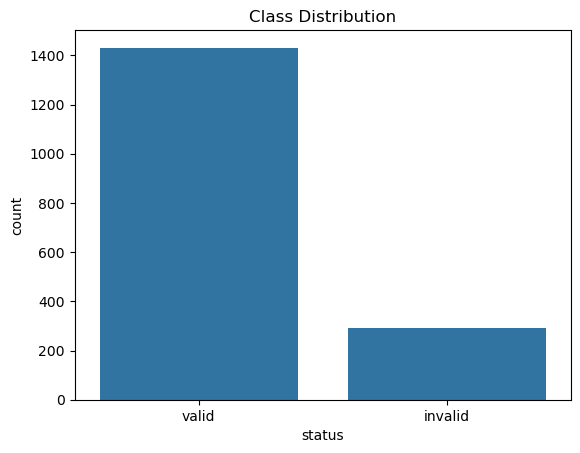

In [37]:
# Plotting class distribution
sns.countplot(x='status', data=dft_ids)
plt.title("Class Distribution")
plt.show()

In [38]:
# Finding number of unique value of categorical variables from total count
print("originator_company column - Unique values:", dft_ids["originator_company"].nunique(), "Total values:", dft_ids["originator_company"].count())
print("beneficiary_company column - Unique values:", dft_ids["beneficiary_company"].nunique(), "Total values:", dft_ids["beneficiary_company"].count())
print("originator_desc column - Unique values:", dft_ids["originator_desc"].nunique(), "Total values:", dft_ids["originator_desc"].count())
print("beneficiary_desc column - Unique values:", dft_ids["beneficiary_desc"].nunique(), "Total values:", dft_ids["beneficiary_desc"].count())

originator_company column - Unique values: 479 Total values: 1723
beneficiary_company column - Unique values: 484 Total values: 1723
originator_desc column - Unique values: 8 Total values: 1723
beneficiary_desc column - Unique values: 8 Total values: 1723


In [40]:
# Converting target from string to integer
dft_ids['status'].replace({'valid':1}, inplace=True)
dft_ids['status'].replace({'invalid':0}, inplace=True)

C:\Users\pravi\AppData\Local\Temp\ipykernel_36016\1306356980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft_ids['status'].replace({'valid':1}, inplace=True)
C:\Users\pravi\AppData\Local\Temp\ipykernel_36016\1306356980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft_ids['status'].replace({'invalid':0}, inplace=True)


In [41]:
dft_ids.head()

,originator_company,originator_country,beneficiary_company,beneficiary_country,amount,currency,status,date,originator_id,originator_desc,beneficiary_id,beneficiary_desc
0,"Deleon, Lewis and Myers",Saint Helena,Golden-Fry,Solomon Islands,33807.85,USD,1,2025-05-31,3511,Electric power generation,3511,Electric power generation
2,Harrison PLC,Cambodia,"Best, Berg and Charles",Kyrgyz Republic,2749.30,USD,1,2025-07-01,3020,Manufacture of railway locomotives,4920,Freight transport by road
5,"Torres, Romero and Bell",Isle of Man,Bowman Group,Jordan,5626.92,USD,1,2025-07-11,4711,Retail sale in non-specialized stores,3511,Electric power generation
6,Anderson Group,Holy See (Vatican City State),Patterson-Guerrero,Antigua and Barbuda,28288.50,USD,1,2025-02-06,111,Crop and animal production,8622,Specialist medical practice activities
10,Taylor Ltd,Hong Kong,Greene-Beard,Guinea-Bissau,15683.39,USD,1,2025-07-24,4920,Freight transport by road,3020,Manufacture of railway locomotives


In [43]:
print("status column - Unique values:", dft_ids["status"].nunique(), "Total values:", dft_ids["status"].count())
dft_ids["status"].value_counts()

status column - Unique values: 2 Total values: 1723


status
1    1431
0     292
Name: count, dtype: int64

In [44]:
dft_ids.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1723 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   originator_company   1723 non-null   object        
 1   originator_country   1723 non-null   object        
 2   beneficiary_company  1723 non-null   object        
 3   beneficiary_country  1723 non-null   object        
 4   amount               1723 non-null   float64       
 5   currency             1723 non-null   object        
 6   status               1723 non-null   int64         
 7   date                 1723 non-null   datetime64[ns]
 8   originator_id        1723 non-null   int64         
 9   originator_desc      1723 non-null   object        
 10  beneficiary_id       1723 non-null   object        
 11  beneficiary_desc     1723 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(8)
memory usage: 175.0+ KB


Iteration 1

In [45]:
# Defining features and target
#features = ["originator_company", "beneficiary_company", "originator_desc", "beneficiary_desc", "originator_id", "beneficiary_id"]
features = ["originator_company", "beneficiary_company", "originator_desc", "beneficiary_desc"]
target = ["status"]

In [31]:
cat_features = ["originator_company", "beneficiary_company", "originator_desc", "beneficiary_desc"]

In [46]:
# Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(dft_ids[features], dft_ids[target], test_size=0.2, random_state=10, stratify=dft_ids[target])
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1378, 6)
X_test shape: (345, 6)
y_train shape: (1378, 1)
y_test shape: (345, 1)


In [49]:
# Train the model
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    verbose=50)
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=30)

0:	test: 0.5204854	best: 0.5204854 (0)	total: 131ms	remaining: 1m 5s
50:	test: 0.5003304	best: 0.5994834 (27)	total: 1.18s	remaining: 10.4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5994833594
bestIteration = 27

Shrink model to first 28 iterations.


In [50]:
# Prediction
y_pred = model.predict(X_test)

In [53]:
unique_values, counts = np.unique(y_pred, return_counts=True)
print("Unique Values:", unique_values)
print("Counts:", counts)

Unique Values: [1]
Counts: [345]


In [51]:
# Evaluating the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        58
           1       0.83      1.00      0.91       287

    accuracy                           0.83       345
   macro avg       0.42      0.50      0.45       345
weighted avg       0.69      0.83      0.76       345



C:\Users\pravi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pravi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pravi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 2

In [75]:
# Defining features and target
features = ["originator_company", "beneficiary_company", "originator_desc", "beneficiary_desc"]
target = ["status"]

In [76]:
cat_features = ["originator_company", "beneficiary_company", "originator_desc", "beneficiary_desc"]

In [77]:
# Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(dft_ids[features], dft_ids[target], test_size=0.2, random_state=10, stratify=dft_ids[target])
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1378, 4)
X_test shape: (345, 4)
y_train shape: (1378, 1)
y_test shape: (345, 1)


In [78]:
# Train the model
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    verbose=50)
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

0:	test: 0.4271597	best: 0.4271597 (0)	total: 23.3ms	remaining: 23.3s
50:	test: 0.5229485	best: 0.5589631 (23)	total: 1.06s	remaining: 19.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5589631143
bestIteration = 23

Shrink model to first 24 iterations.


In [79]:
# Prediction
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [82]:
unique_values, counts = np.unique(y_pred_train, return_counts=True)
print("Train Data - Unique Values:", unique_values, "Counts:", counts)
unique_values, counts = np.unique(y_pred_test, return_counts=True)
print("Test Data - Unique Values:", unique_values, "Counts:", counts)

Train Data - Unique Values: [1] Counts: [1378]
Test Data - Unique Values: [1] Counts: [345]


In [81]:
# Evaluating the model
print("Train report")
print(classification_report(y_train, y_pred_train))
print("Test report")
print(classification_report(y_test, y_pred_test))

Train report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.83      1.00      0.91      1144

    accuracy                           0.83      1378
   macro avg       0.42      0.50      0.45      1378
weighted avg       0.69      0.83      0.75      1378

Test report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        58
           1       0.83      1.00      0.91       287

    accuracy                           0.83       345
   macro avg       0.42      0.50      0.45       345
weighted avg       0.69      0.83      0.76       345



C:\Users\pravi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pravi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pravi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pravi\anaconda3\Lib\site-packag

Iteration 3

In [ ]:
# Using train, test and features data from above

In [92]:
model = CatBoostClassifier(loss_function='Logloss', eval_metric='F1', random_seed=42, verbose=0)

param_grid = {
    'iterations': [100, 300, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    
}


In [93]:
grid_result = model.grid_search(
    param_grid,
    X=train_pool,
    cv=3,
    shuffle=True,
    stratified=True,
    plot=False  # Set True if you want live charts
)



bestTest = 0.8915662651
bestIteration = 0

0:	loss: 0.8915663	best: 0.8915663 (0)	total: 1.51s	remaining: 2m

bestTest = 0.8915662651
bestIteration = 0

1:	loss: 0.8915663	best: 0.8915663 (0)	total: 3.23s	remaining: 2m 7s

bestTest = 0.8915662651
bestIteration = 0

2:	loss: 0.8915663	best: 0.8915663 (0)	total: 5.19s	remaining: 2m 14s

bestTest = 0.8915662651
bestIteration = 0

3:	loss: 0.8915663	best: 0.8915663 (0)	total: 6.42s	remaining: 2m 3s

bestTest = 0.8915662651
bestIteration = 0

4:	loss: 0.8915663	best: 0.8915663 (0)	total: 8.16s	remaining: 2m 4s

bestTest = 0.8915662651
bestIteration = 0

5:	loss: 0.8915663	best: 0.8915663 (0)	total: 10.1s	remaining: 2m 5s

bestTest = 0.8915662651
bestIteration = 0

6:	loss: 0.8915663	best: 0.8915663 (0)	total: 11.4s	remaining: 2m

bestTest = 0.8915662651
bestIteration = 0

7:	loss: 0.8915663	best: 0.8915663 (0)	total: 13s	remaining: 1m 59s

bestTest = 0.8915662651
bestIteration = 0

8:	loss: 0.8915663	best: 0.8915663 (0)	total: 15s	remainin

In [94]:
# Get best parameters
# Best parameters
best_params = grid_result['params']
print("Best Parameters Found:")
for param, value in best_params.items():
    print(f"   {param}: {value}")


Best Parameters Found:
   depth: 4
   learning_rate: 0.01
   l2_leaf_reg: 1
   iterations: 100


In [95]:
# Train model with best parameters
best_model = CatBoostClassifier(**best_params, loss_function='Logloss', eval_metric='F1', verbose=0, random_seed=42)

# Train using train_pool & validate on test_pool
best_model.fit(train_pool, eval_set=test_pool, use_best_model=True)


In [96]:
ytrain_predict_cl = best_model.predict(X_train)
ytest_predict_cl = best_model.predict(X_test)

In [99]:
print('Accuracy Score for train dataset is',round(accuracy_score(y_train, ytrain_predict_cl),2)*100,'%')
print("\n")
print('Accuracy Score for test dataset is',round(accuracy_score(y_test, ytest_predict_cl),2)*100,'%')

Accuracy Score for train dataset is 83.0 %


Accuracy Score for test dataset is 83.0 %


In [100]:
unique_values, counts = np.unique(y_pred_train, return_counts=True)
print("Train Data - Unique Values:", unique_values, "Counts:", counts)
unique_values, counts = np.unique(y_pred_test, return_counts=True)
print("Test Data - Unique Values:", unique_values, "Counts:", counts)

Train Data - Unique Values: [1] Counts: [1378]
Test Data - Unique Values: [1] Counts: [345]


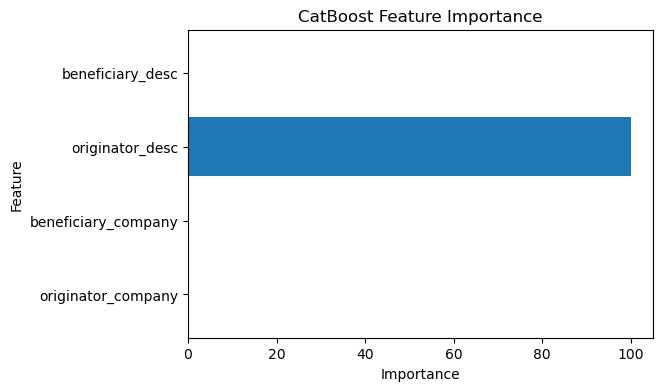

In [101]:
# Feature importance
import matplotlib.pyplot as plt

feature_importances = best_model.get_feature_importance(train_pool)
plt.figure(figsize=(6,4))
plt.barh(X_train.columns, feature_importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost Feature Importance")
plt.show()


In [ ]:
# Saving model as pkl file
with open('TransactionAnalysis_catboost.pkl', 'wb') as f:
    pickle.dump(model,f)